# Data Modeling
Author: Long Nguyen (long.nguyen@visa.com)

First, load necessary libraries and data

In [1]:
library(ggplot2)
library(caret)
library(corrplot)
library(pROC)
library(ROCR)
library(e1071)
library(randomForest)
library(gbm)
library(xgboost)

##Load the hackathon dataset
# data <- read.csv("C:/Users/nlong/Documents/GitHub/CEMEA presentation/KSS/loan_prediction.csv", stringsAsFactors = T)
data<-read.csv(url('https://datahack-prod.s3.ap-south-1.amazonaws.com/train_file/train_u6lujuX_CVtuZ9i.csv'))
#Looking at the structure of the data
head(data)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: lattice
corrplot 0.84 loaded
Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Loaded gbm 2.1.5


Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
LP001002,Male,No,0,Graduate,No,5849,0,NA,360,1,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
LP001011,Male,Yes,2,Graduate,Yes,5417,4196,267,360,1,Urban,Y


Show data structure and summary

In [2]:
str(data)

'data.frame':	614 obs. of  13 variables:
 $ Loan_ID          : Factor w/ 614 levels "LP001002","LP001003",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Gender           : Factor w/ 3 levels "","Female","Male": 3 3 3 3 3 3 3 3 3 3 ...
 $ Married          : Factor w/ 3 levels "","No","Yes": 2 3 3 3 2 3 3 3 3 3 ...
 $ Dependents       : Factor w/ 5 levels "","0","1","2",..: 2 3 2 2 2 4 2 5 4 3 ...
 $ Education        : Factor w/ 2 levels "Graduate","Not Graduate": 1 1 1 2 1 1 2 1 1 1 ...
 $ Self_Employed    : Factor w/ 3 levels "","No","Yes": 2 2 3 2 2 3 2 2 2 2 ...
 $ ApplicantIncome  : int  5849 4583 3000 2583 6000 5417 2333 3036 4006 12841 ...
 $ CoapplicantIncome: num  0 1508 0 2358 0 ...
 $ LoanAmount       : int  NA 128 66 120 141 267 95 158 168 349 ...
 $ Loan_Amount_Term : int  360 360 360 360 360 360 360 360 360 360 ...
 $ Credit_History   : int  1 1 1 1 1 1 1 0 1 1 ...
 $ Property_Area    : Factor w/ 3 levels "Rural","Semiurban",..: 3 1 3 3 3 3 3 2 3 2 ...
 $ Loan_Status      : Factor w/ 2 le

In [3]:
summary(data)

     Loan_ID       Gender    Married   Dependents        Education  
 LP001002:  1         : 13      :  3     : 15     Graduate    :480  
 LP001003:  1   Female:112   No :213   0 :345     Not Graduate:134  
 LP001005:  1   Male  :489   Yes:398   1 :102                       
 LP001006:  1                          2 :101                       
 LP001008:  1                          3+: 51                       
 LP001011:  1                                                       
 (Other) :608                                                       
 Self_Employed ApplicantIncome CoapplicantIncome   LoanAmount   
    : 32       Min.   :  150   Min.   :    0     Min.   :  9.0  
 No :500       1st Qu.: 2878   1st Qu.:    0     1st Qu.:100.0  
 Yes: 82       Median : 3812   Median : 1188     Median :128.0  
               Mean   : 5403   Mean   : 1621     Mean   :146.4  
               3rd Qu.: 5795   3rd Qu.: 2297     3rd Qu.:168.0  
               Max.   :81000   Max.   :41667     Max.   :7

### Explore the data

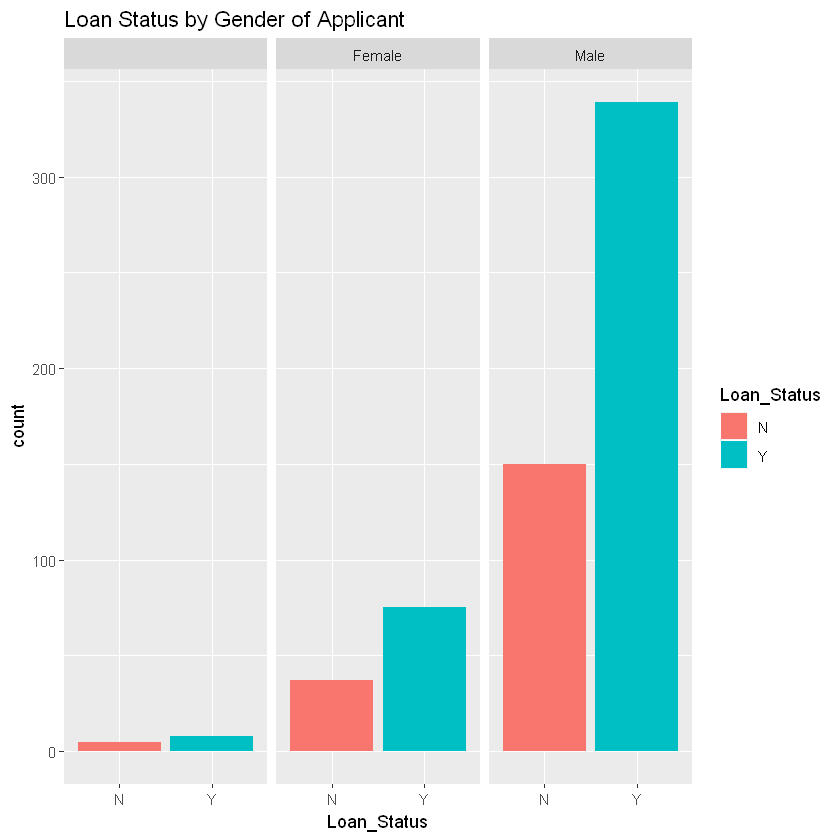

In [4]:
ggplot(data, aes(x=Loan_Status, fill=Loan_Status))+geom_bar()+facet_grid(.~Gender)+ggtitle("Loan Status by Gender of Applicant")


### Imputing missing values using median

In [5]:
#Does the data contain missing values
cat('#Rows of missing value: ' , sum(is.na(data)), '\n')
preProcValues <- preProcess(data, method = c("medianImpute","center","scale"))
library('RANN')
data_processed <- predict(preProcValues, data)
cat('#Rows of missing value of imputed data: ', sum(is.na(data_processed)))

#Rows of missing value:  86 
#Rows of missing value of imputed data:  0

In [6]:
#Converting outcome variable to numeric
data_processed$Loan_Status <- ifelse(data_processed$Loan_Status == 'N', 0, 1)

id <- data_processed$Loan_ID
data_processed$Loan_ID <- NULL
#Converting every categorical variable to numerical using dummy variables
dmy <- dummyVars(" ~ .", data = data_processed, fullRank = T)
data_transformed <- data.frame(predict(dmy, newdata = data_processed))
# data_transformed$Loan_Status <-  as.factor(data_transformed$Loan_Status)
data_transformed$Loan_Status <-  data$Loan_Status
str(data_transformed)
# data_transformed<-data_processed

'data.frame':	614 obs. of  19 variables:
 $ Gender.Female          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Gender.Male            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Married.No             : num  1 0 0 0 1 0 0 0 0 0 ...
 $ Married.Yes            : num  0 1 1 1 0 1 1 1 1 1 ...
 $ Dependents.0           : num  1 0 1 1 1 0 1 0 0 0 ...
 $ Dependents.1           : num  0 1 0 0 0 0 0 0 0 1 ...
 $ Dependents.2           : num  0 0 0 0 0 1 0 0 1 0 ...
 $ Dependents.3.          : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Education.Not.Graduate : num  0 0 0 1 0 0 1 0 0 0 ...
 $ Self_Employed.No       : num  1 1 0 1 1 0 1 1 1 1 ...
 $ Self_Employed.Yes      : num  0 0 1 0 0 1 0 0 0 0 ...
 $ ApplicantIncome        : num  0.0729 -0.1343 -0.3934 -0.4617 0.0976 ...
 $ CoapplicantIncome      : num  -0.554 -0.0387 -0.554 0.2518 -0.554 ...
 $ LoanAmount             : num  -0.2151 -0.2151 -0.9395 -0.3086 -0.0632 ...
 $ Loan_Amount_Term       : num  0.276 0.276 0.276 0.276 0.276 ...
 $ Credit_History         : num  0.432 0

## Prepare training and testing sets
Spliting training set into two parts based on outcome: 75% and 25%

In [7]:
set.seed(123456)
#Spliting training set into two parts based on outcome: 75% and 25%
index <- createDataPartition(data$Loan_Status, p=0.75, list=FALSE)
trainSet <- data_transformed[ index,]
testSet <- data_transformed[-index,]

#Defining the training controls for multiple models
fitControl <- trainControl(
  method = "cv",
  number = 5,
savePredictions = 'final',
classProbs = T)

In [8]:
outcomeName <- 'Loan_Status'
predictors <- names(trainSet)[!names(trainSet) %in% outcomeName]
# predictors <- c("Credit_History", "LoanAmount", "Loan_Amount_Term", "ApplicantIncome", "CoapplicantIncome")

In [9]:
str(trainSet)

'data.frame':	461 obs. of  19 variables:
 $ Gender.Female          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Gender.Male            : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Married.No             : num  0 0 0 1 0 0 0 0 0 0 ...
 $ Married.Yes            : num  1 1 1 0 1 1 1 1 1 1 ...
 $ Dependents.0           : num  0 1 1 1 0 1 0 0 0 0 ...
 $ Dependents.1           : num  1 0 0 0 0 0 0 0 1 0 ...
 $ Dependents.2           : num  0 0 0 0 1 0 0 1 0 1 ...
 $ Dependents.3.          : num  0 0 0 0 0 0 1 0 0 0 ...
 $ Education.Not.Graduate : num  0 0 1 0 0 1 0 0 0 0 ...
 $ Self_Employed.No       : num  1 0 1 1 0 1 1 1 1 1 ...
 $ Self_Employed.Yes      : num  0 1 0 0 1 0 0 0 0 0 ...
 $ ApplicantIncome        : num  -0.1343 -0.39343 -0.46169 0.09765 0.00222 ...
 $ CoapplicantIncome      : num  -0.0387 -0.554 0.2518 -0.554 0.8799 ...
 $ LoanAmount             : num  -0.2151 -0.9395 -0.3086 -0.0632 1.4089 ...
 $ Loan_Amount_Term       : num  0.276 0.276 0.276 0.276 0.276 ...
 $ Credit_History         : num  0.43

### Training the Logistic regression model

In [10]:
model_lr<-train(trainSet[,predictors],trainSet[,outcomeName],method='glm',trControl=fitControl,tuneLength=3)
#Predicting the Logistic regression model
testSet$pred_lr<-predict(object = model_lr,testSet[,predictors])
#Checking the accuracy of the random forest model
confusionMatrix(testSet$Loan_Status,testSet$pred_lr)
testSet$pred_lr<-predict(object = model_lr,testSet[,predictors])
lr.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$pred_lr))
cat("LR AUC ", auc(lr.roc_obj))

Confusion Matrix and Statistics

          Reference
Prediction   N   Y
         N  24  24
         Y   5 100
                                          
               Accuracy : 0.8105          
                 95% CI : (0.7393, 0.8692)
    No Information Rate : 0.8105          
    P-Value [Acc > NIR] : 0.5494430       
                                          
                  Kappa : 0.5068          
                                          
 Mcnemar's Test P-Value : 0.0008302       
                                          
            Sensitivity : 0.8276          
            Specificity : 0.8065          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.9524          
             Prevalence : 0.1895          
         Detection Rate : 0.1569          
   Detection Prevalence : 0.3137          
      Balanced Accuracy : 0.8170          
                                          
       'Positive' Class : N               
                              

Setting levels: control = N, case = Y
Setting direction: controls < cases


LR AUC  0.7261905

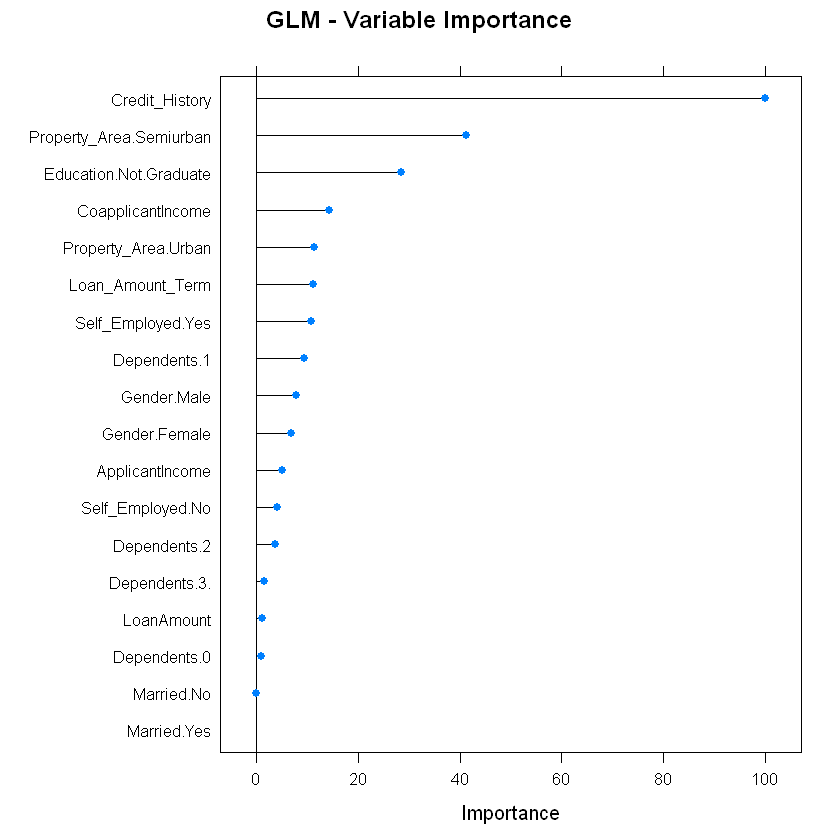

In [11]:
plot(varImp(object = model_lr), main = "GLM - Variable Importance")


### Training the random forest model

In [12]:
model_rf<-train(trainSet[,predictors],trainSet[,outcomeName],method='rf',trControl=fitControl,tuneLength=3)
#Predicting the Logistic regression model
testSet$pred_rf<-predict(object = model_rf,testSet[,predictors])
#Checking the AUC of the random forest model
rf.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$pred_rf))
cat("RF AUC ", auc(rf.roc_obj))

Setting levels: control = N, case = Y
Setting direction: controls < cases


RF AUC  0.7244048

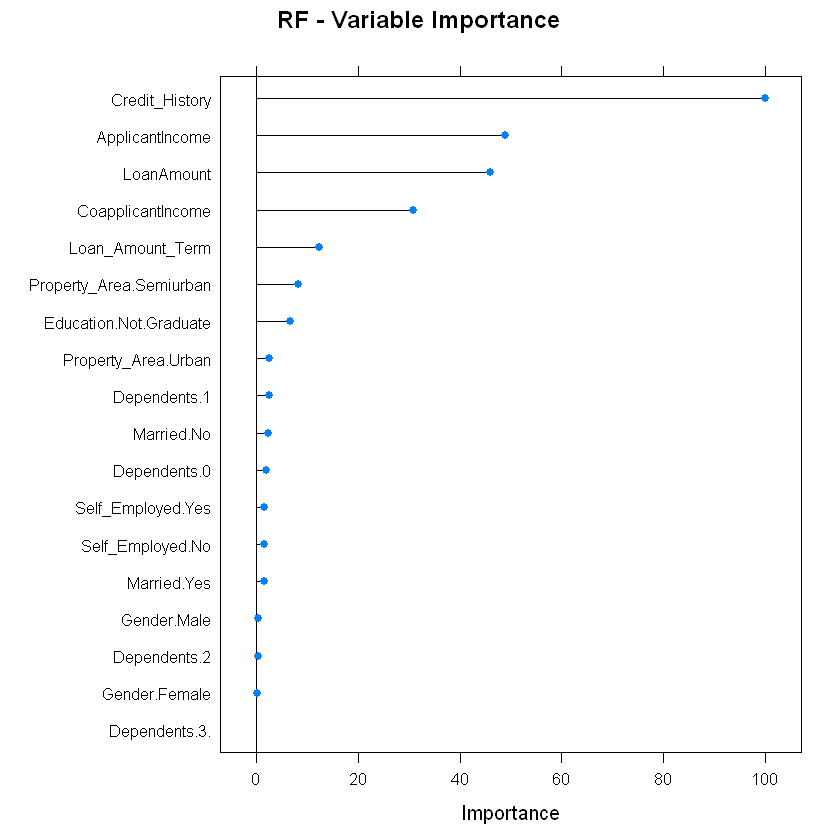

In [13]:
plot(varImp(object = model_rf), main = "RF - Variable Importance")

In [14]:
model_gbm<-train(trainSet[,predictors],trainSet[,outcomeName],method='gbm')
#Predicting the Logistic regression model
testSet$pred_gbm<-predict(object = model_gbm,testSet[,predictors])
#Checking the accuracy of the random forest model
gbm.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$pred_gbm))
cat("GBM AUC ", auc(gbm.roc_obj))

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.1043             nan     0.1000    0.0227
     2        1.0669             nan     0.1000    0.0202
     3        1.0392             nan     0.1000    0.0127
     4        1.0191             nan     0.1000    0.0097
     5        0.9991             nan     0.1000    0.0085
     6        0.9832             nan     0.1000    0.0078
     7        0.9712             nan     0.1000    0.0045
     8        0.9621             nan     0.1000    0.0040
     9        0.9533             nan     0.1000    0.0038
    10        0.9461             nan     0.1000    0.0034
    20        0.9023             nan     0.1000   -0.0010
    40        0.8529             nan     0.1000    0.0001
    60        0.8222             nan     0.1000    0.0000
    80        0.7918             nan     0.1000   -0.0019
   100        0.7748             nan     0.1000   -0.0010
   120        0.7624             nan     0.1000   -0.0008
   140        

Setting levels: control = N, case = Y
Setting direction: controls < cases


GBM AUC  0.7244048

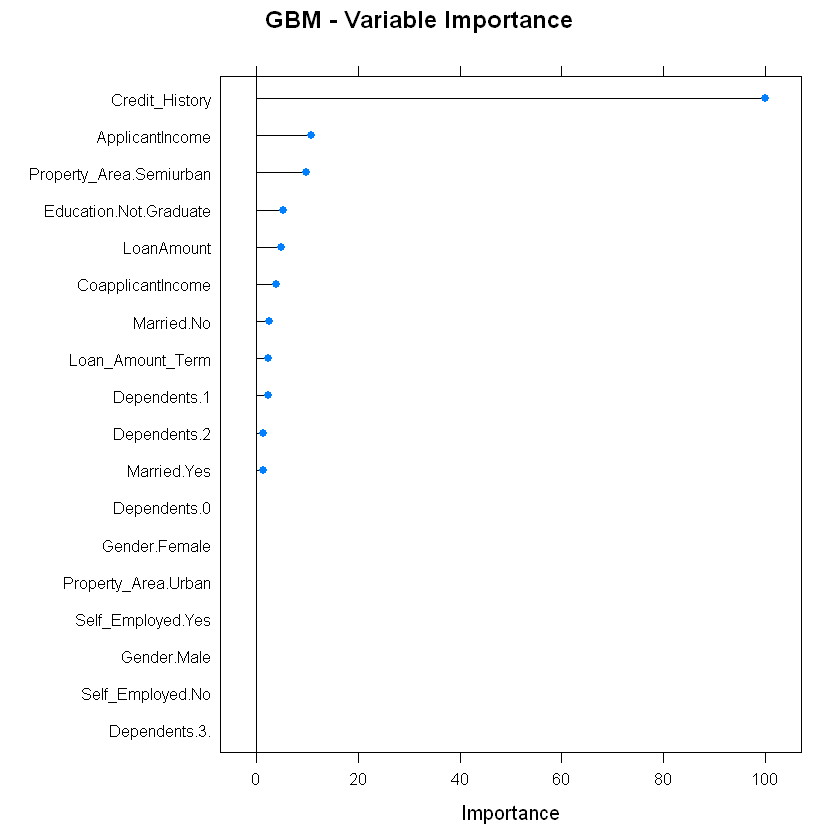

In [15]:
plot(varImp(object = model_gbm), main = "GBM - Variable Importance")


# Fine tune using tuneGrid

model,parameter,label,forReg,forClass,probModel
gbm,n.trees,# Boosting Iterations,TRUE,TRUE,TRUE
gbm,interaction.depth,Max Tree Depth,TRUE,TRUE,TRUE
gbm,shrinkage,Shrinkage,TRUE,TRUE,TRUE
gbm,n.minobsinnode,Min. Terminal Node Size,TRUE,TRUE,TRUE


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2352             nan     0.0100    0.0027
     2        1.2299             nan     0.0100    0.0019
     3        1.2252             nan     0.0100    0.0023
     4        1.2208             nan     0.0100    0.0023
     5        1.2167             nan     0.0100    0.0025
     6        1.2121             nan     0.0100    0.0024
     7        1.2078             nan     0.0100    0.0023
     8        1.2035             nan     0.0100    0.0019
     9        1.1995             nan     0.0100    0.0019
    10        1.1957             nan     0.0100    0.0019
    20        1.1597             nan     0.0100    0.0017
    40        1.1088             nan     0.0100    0.0010
    60        1.0731             nan     0.0100    0.0006
    80        1.0480             nan     0.0100    0.0005
   100        1.0327             nan     0.0100    0.0001

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1       

Stochastic Gradient Boosting 

461 samples
 18 predictor
  2 classes: 'N', 'Y' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 369, 369, 368, 369, 369, 370, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.minobsinnode  n.trees  Accuracy   Kappa    
  0.01        1                 3                10      0.6876398  0.0000000
  0.01        1                 3                20      0.6876398  0.0000000
  0.01        1                 3                50      0.8046969  0.4625739
  0.01        1                 3               100      0.8046969  0.4625739
  0.01        1                 5                10      0.6876398  0.0000000
  0.01        1                 5                20      0.6876398  0.0000000
  0.01        1                 5                50      0.8046969  0.4625739
  0.01        1                 5               100      0.8046969  0.4625739
  0.01        5                 3    

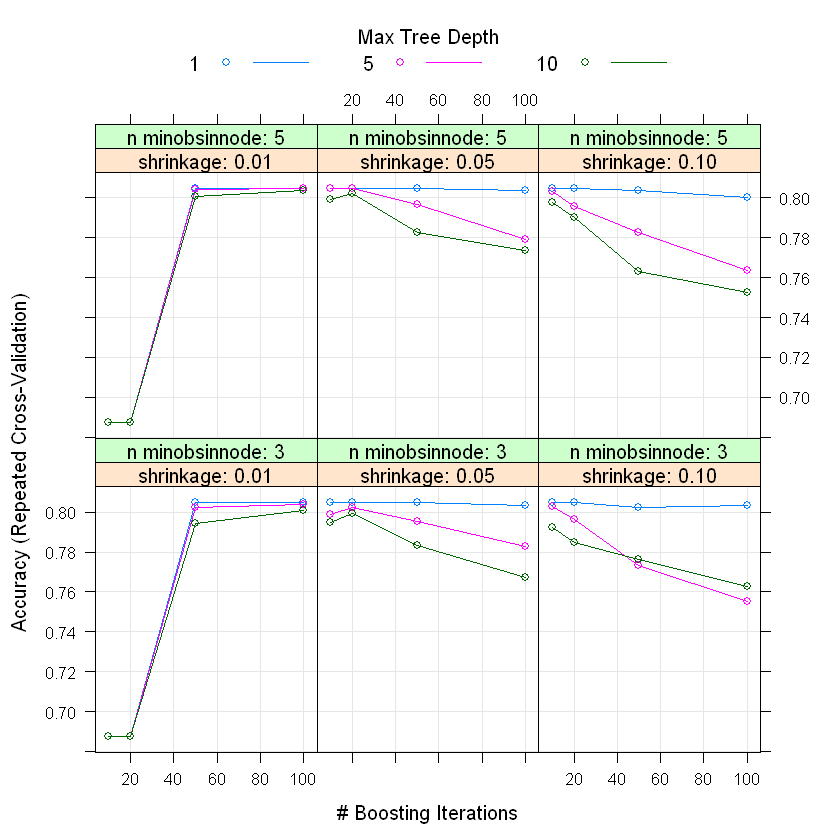

In [16]:
# It will take a few minutes to run the grid search tunning
modelLookup(model='gbm')
#Creating grid
grid <- expand.grid(n.trees=c(10,20,50,100),shrinkage=c(0.01,0.05,0.1),n.minobsinnode = c(3,5),interaction.depth=c(1,5,10))

fitControl <- trainControl(
  method = "repeatedcv",
  number = 5,
  repeats = 5)
# training the model
time1 <- Sys.time()
model_gbm_grid<-train(trainSet[,predictors],trainSet[,outcomeName],method='gbm',trControl=fitControl,tuneGrid=grid)

# summarizing the model
print(model_gbm_grid)
plot(model_gbm_grid)


In [17]:
cat( "Training time (mins): ", difftime(Sys.time(), time1, units = 'mins'))

Training time (mins):  0.4119887

In [18]:
#Predictions
testSet$pred_gbm_grid<-predict(object = model_gbm_grid,testSet[,predictors])
gbm_grid.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$pred_gbm_grid))
cat("GBM AUC ", auc(gbm_grid.roc_obj))

Setting levels: control = N, case = Y
Setting direction: controls < cases


GBM AUC  0.7244048

### Summary of AUC of trained models

In [19]:
cat("LR AUC ", auc(lr.roc_obj), '\n')
cat("RF AUC ", auc(rf.roc_obj), '\n')
cat("GBM AUC ", auc(gbm.roc_obj), '\n')
cat("GBM_grid AUC ", auc(gbm_grid.roc_obj), '\n')

LR AUC  0.7261905 
RF AUC  0.7244048 
GBM AUC  0.7244048 
GBM_grid AUC  0.7244048 


## Extreme Gradiant Boosting (xgboost)

In [20]:
library(xgboost)
cv <- createFolds(trainSet[, outcomeName], k = 10)
xgb.train.data = xgb.DMatrix(data.matrix(trainSet[, predictors]),
                             label = ifelse(trainSet[, outcomeName] == 'N', 0, 1),
                             missing = NA)
param <- list(objective = "binary:logistic", base_score = 0.5)
xgboost.cv = xgb.cv(
  param = param,
  data = xgb.train.data,
  folds = cv,
  nrounds = 1500,
  early_stopping_rounds = 100,
  metrics = 'auc',
  eta = 0.05
)


[1]	train-auc:0.849620+0.018354	test-auc:0.700259+0.072156 
Multiple eval metrics are present. Will use test_auc for early stopping.
Will train until test_auc hasn't improved in 100 rounds.

[2]	train-auc:0.884773+0.019774	test-auc:0.713956+0.071341 
[3]	train-auc:0.889421+0.022846	test-auc:0.714371+0.075027 
[4]	train-auc:0.897871+0.020163	test-auc:0.721143+0.068016 
[5]	train-auc:0.900965+0.019997	test-auc:0.724911+0.070703 
[6]	train-auc:0.909029+0.018728	test-auc:0.736174+0.063942 
[7]	train-auc:0.914625+0.016510	test-auc:0.732885+0.061651 
[8]	train-auc:0.916464+0.016967	test-auc:0.736654+0.064149 
[9]	train-auc:0.919648+0.014474	test-auc:0.736505+0.060574 
[10]	train-auc:0.922325+0.013381	test-auc:0.736026+0.060188 
[11]	train-auc:0.925814+0.010941	test-auc:0.735372+0.058766 
[12]	train-auc:0.927396+0.009355	test-auc:0.735507+0.060662 
[13]	train-auc:0.930550+0.008825	test-auc:0.739166+0.062493 
[14]	train-auc:0.933456+0.008003	test-auc:0.737226+0.061668 
[15]	train-auc:0.936139+

In [21]:
best_iteration = xgboost.cv$best_iteration
xgb.model <- xgboost(param = param, data = xgb.train.data, nrounds = best_iteration, eta = 0.1)
xgb.test.data = xgb.DMatrix(data.matrix(testSet[, predictors]), missing = NA)
pred_xgb = predict(xgb.model, xgb.test.data)

[1]	train-error:0.164859 
[2]	train-error:0.160521 
[3]	train-error:0.160521 
[4]	train-error:0.167028 
[5]	train-error:0.164859 
[6]	train-error:0.158351 
[7]	train-error:0.156182 
[8]	train-error:0.164859 
[9]	train-error:0.160521 
[10]	train-error:0.158351 
[11]	train-error:0.149675 
[12]	train-error:0.151844 
[13]	train-error:0.149675 
[14]	train-error:0.149675 
[15]	train-error:0.145336 
[16]	train-error:0.145336 
[17]	train-error:0.136659 
[18]	train-error:0.136659 
[19]	train-error:0.140998 
[20]	train-error:0.134490 
[21]	train-error:0.136659 
[22]	train-error:0.127983 
[23]	train-error:0.132321 
[24]	train-error:0.130152 
[25]	train-error:0.121475 
[26]	train-error:0.123644 
[27]	train-error:0.125813 
[28]	train-error:0.123644 
[29]	train-error:0.125813 
[30]	train-error:0.127983 
[31]	train-error:0.117137 
[32]	train-error:0.117137 
[33]	train-error:0.112798 
[34]	train-error:0.108460 
[35]	train-error:0.101952 
[36]	train-error:0.101952 
[37]	train-error:0.097614 
[38]	train

Setting levels: control = N, case = Y
Setting direction: controls < cases


XGB AUC  0.7843254

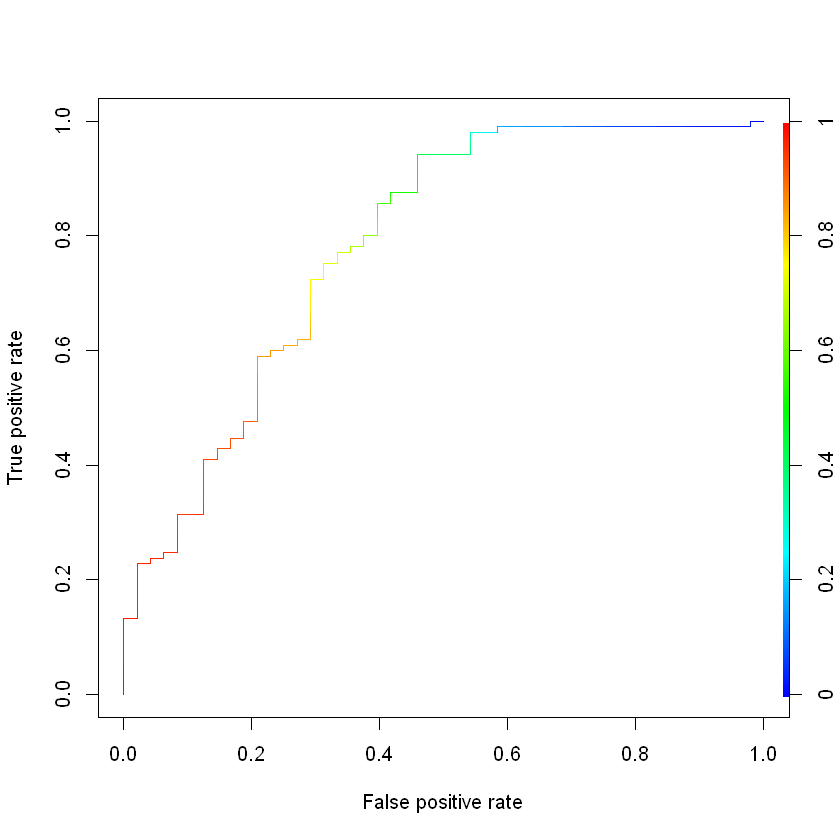

In [22]:
pred <- prediction(pred_xgb, testSet[,outcomeName])
perf <- performance(pred, "tpr", "fpr")
plot(perf, colorize=T)

xgb.roc_obj <- roc(testSet[, outcomeName], pred_xgb)
cat("XGB AUC ", auc(xgb.roc_obj))



In [23]:
best_cutoff <- function(predict, response) {
    perf <- ROCR::performance(ROCR::prediction(predict, response), "sens", "spec")
    df <- data.frame(cut = perf@alpha.values[[1]], sens = perf@x.values[[1]], spec = perf@y.values[[1]])
    df[which.max(df$sens + df$spec), "cut"]
}
thresh = best_cutoff(pred_xgb, ifelse(testSet[, outcomeName] == 'N', 0, 1))
testSet$pred_xgb <- ifelse(pred_xgb >=thresh, 'Y', 'N')
table(testSet$pred_xgb)
confusionMatrix(as.factor(testSet[, outcomeName]), as.factor(testSet$pred_xgb))
xgb.roc_obj <- roc(testSet[, outcomeName], pred_xgb)
cat("XGB AUC ", auc(xgb.roc_obj))


  N   Y 
 32 121 

Confusion Matrix and Statistics

          Reference
Prediction  N  Y
         N 26 22
         Y  6 99
                                          
               Accuracy : 0.817           
                 95% CI : (0.7465, 0.8748)
    No Information Rate : 0.7908          
    P-Value [Acc > NIR] : 0.246497        
                                          
                  Kappa : 0.5327          
                                          
 Mcnemar's Test P-Value : 0.004586        
                                          
            Sensitivity : 0.8125          
            Specificity : 0.8182          
         Pos Pred Value : 0.5417          
         Neg Pred Value : 0.9429          
             Prevalence : 0.2092          
         Detection Rate : 0.1699          
   Detection Prevalence : 0.3137          
      Balanced Accuracy : 0.8153          
                                          
       'Positive' Class : N               
                                    

Setting levels: control = N, case = Y
Setting direction: controls < cases


XGB AUC  0.7843254

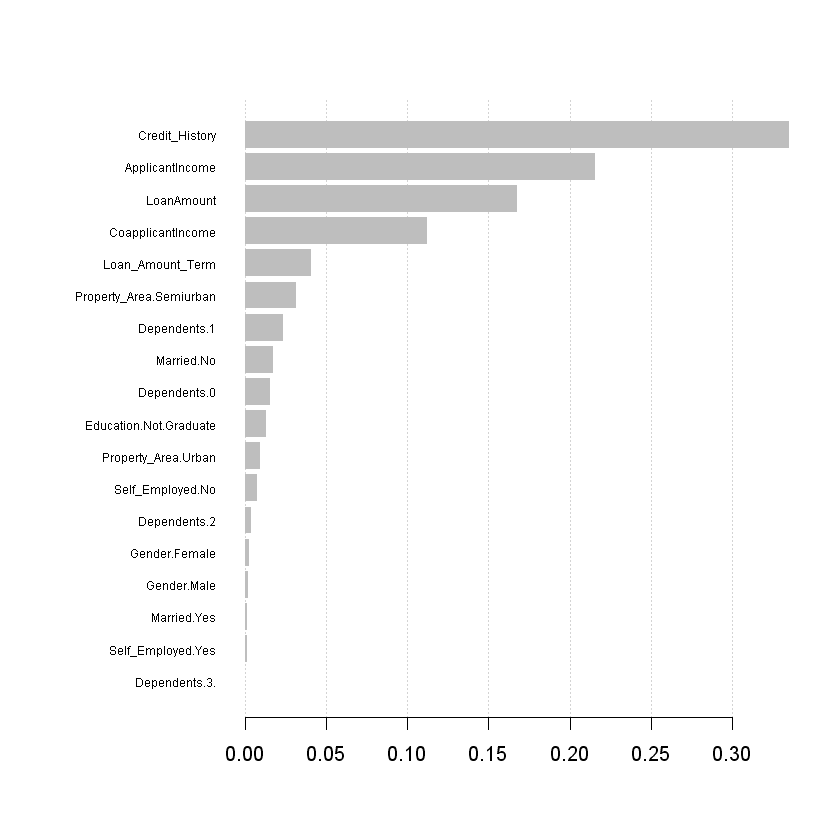

In [24]:
# Xgb importance
col_names = attr(xgb.train.data, ".Dimnames")[[2]]
imp = xgb.importance(col_names, xgb.model)
xgb.plot.importance(imp)

# Ensemble Models

- **Averaging** : We can do averaging on the probabilities of observations to be in wither of these binary classes.

In [25]:
#Predicting the probabilities
testSet$pred_rf_prob<-predict(object = model_rf,testSet[,predictors],type='prob')$Y
testSet$pred_gbm_prob<-predict(object = model_gbm,testSet[,predictors],type='prob')$Y
testSet$pred_lr_prob<-predict(object = model_lr,testSet[,predictors],type='prob')$Y

#Taking average of predictions
testSet$pred_avg<-(testSet$pred_rf_prob+testSet$pred_gbm_prob+testSet$pred_lr_prob)/3

avg.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$pred_avg))
cat("Averaging AUC ", auc(avg.roc_obj))

Setting levels: control = N, case = Y
Setting direction: controls < cases


Averaging AUC  0.7630952

- **Majority voting:** In majority voting, we’ll assign the prediction for the observation as predicted by the majority of models. Since we have three models for a binary classification task, a tie is not possible.

In [26]:
#The majority vote
testSet$pred_majority<-as.factor(ifelse(testSet$pred_rf=='Y' & testSet$pred_gbm=='Y','Y',ifelse(testSet$pred_rf=='Y' & testSet$pred_lr=='Y','Y',ifelse(testSet$pred_gbm=='Y' & testSet$pred_lr=='Y','Y','N'))))
maj.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$pred_majority))
cat("Majority voting AUC ", auc(maj.roc_obj))

Setting levels: control = N, case = Y
Setting direction: controls < cases


Majority voting AUC  0.7244048

- **Weighted Average:** Instead of taking simple average, we can take weighted average. Generally, the weights of predictions are high for more accurate models. Let’s assign 0.5 to logistic regression and 0.25 to KNN and random forest each.

In [27]:
#Taking weighted average of predictions
testSet$pred_weighted_avg<-(testSet$pred_rf_prob*0.25)+(testSet$pred_gbm_prob*0.25)+(testSet$pred_lr_prob*0.5)
weighted_avg.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$pred_weighted_avg))
cat("Majority voting AUC ", auc(weighted_avg.roc_obj))

Setting levels: control = N, case = Y
Setting direction: controls < cases


Majority voting AUC  0.7561508

## Stacking

In [28]:
#Predicting the out of fold prediction probabilities for training data
trainSet$pred_rf_prob<-predict(model_rf,trainSet[predictors],type='prob')$Y
trainSet$pred_gbm_prob<-predict(model_gbm,trainSet[predictors],type='prob')$Y
trainSet$pred_lr_prob<-predict(model_lr,trainSet[predictors],type='prob')$Y

#Predicting probabilities for the test data
testSet$pred_rf_prob<-predict(model_rf,testSet[predictors],type='prob')$Y
testSet$pred_gbm_prob<-predict(model_gbm,testSet[predictors],type='prob')$Y
testSet$pred_lr_prob<-predict(model_lr,testSet[predictors],type='prob')$Y

In [29]:
#Predictors for top layer models 
predictors_top<-c('pred_rf_prob','pred_gbm_prob','pred_lr_prob') 
library(ggcorrplot)
corr <- round(cor(trainSet[,predictors_top]), 2)
corr

,pred_rf_prob,pred_gbm_prob,pred_lr_prob
pred_rf_prob,1.00,0.87,0.85
pred_gbm_prob,0.87,1.00,0.96
pred_lr_prob,0.85,0.96,1.00


In [30]:
#GBM as top layer model 
model_gbm<- 
train(trainSet[,predictors_top],trainSet[,outcomeName],method='gbm',trControl=fitControl,tuneLength=3)

#Logistic regression as top layer model
model_glm<-
train(trainSet[,predictors_top],trainSet[,outcomeName],method='glm',trControl=fitControl,tuneLength=3)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0735             nan     0.1000    0.0836
     2        0.9543             nan     0.1000    0.0635
     3        0.8493             nan     0.1000    0.0510
     4        0.7627             nan     0.1000    0.0409
     5        0.6930             nan     0.1000    0.0356
     6        0.6263             nan     0.1000    0.0298
     7        0.5743             nan     0.1000    0.0252
     8        0.5289             nan     0.1000    0.0224
     9        0.4890             nan     0.1000    0.0179
    10        0.4553             nan     0.1000    0.0153
    20        0.2759             nan     0.1000    0.0044
    40        0.1904             nan     0.1000   -0.0004
    60        0.1563             nan     0.1000   -0.0013
    80        0.1287             nan     0.1000   -0.0001
   100        0.1079             nan     0.1000   -0.0008
   120        0.0938             nan     0.1000   -0.0003
   140        

In [31]:
#predict using GBM top layer model
testSet$gbm_stacked<-predict(model_gbm,testSet[,predictors_top],type='prob')$Y

#predict using logictic regression top layer model
testSet$glm_stacked<-predict(model_glm,testSet[,predictors_top],type='prob')$Y

In [32]:
# confusionMatrix(as.factor(testSet[, outcomeName]), as.factor(testSet$gbm_stacked))
gbm_stacked.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$gbm_stacked))
cat("Majority voting AUC ", auc(gbm_stacked.roc_obj))

Setting levels: control = N, case = Y
Setting direction: controls < cases


Majority voting AUC  0.7355159

In [33]:
# confusionMatrix(as.factor(testSet[, outcomeName]), as.factor(testSet$glm_stacked))
gbm_stacked.roc_obj <- roc(testSet[, outcomeName], as.numeric(testSet$glm_stacked))
cat("glm_stacked AUC ", auc(gbm_stacked.roc_obj))

Setting levels: control = N, case = Y
Setting direction: controls < cases


glm_stacked AUC  0.6928571

## Reference:
- https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/beginners-tutorial-on-xgboost-parameter-tuning-r/tutorial/
- https://mlwave.com/kaggle-ensembling-guide/
- https://machinelearningmastery.com/machine-learning-ensembles-with-r/
- https://www.analyticsvidhya.com/blog/2017/02/introduction-to-ensembling-along-with-implementation-in-r/
